# Section 3: **Move Characteristics by Skill Level**

In [3]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import warnings
import pyarrow.parquet as pq

print("Libraries imported successfully.")

Libraries imported successfully.


In [4]:
# Configuration
DATASET_DIR = Path(r"E:\EDA_chess_data\processed")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)  # Ignore userwarnings from seaborn / matplotlib

# Analysis constants
TARGET_TIME_CONTROLS = ['60+0', '180+0']; 
TOP_N_CONTROLS = 5

# ELO bins
elo_bins = [500, 1200, 1900, 2300, np.inf]
elo_labels = ['Beginner (500-1200)', 'Intermediate (1200-1900)', 'Advanced (1900-2300)', 'Expert (2300+)']
tight_bin_width = 100
tight_elo_bins = np.arange(500, 2800 + tight_bin_width, tight_bin_width)
tight_elo_labels = [f'{tight_elo_bins[i]}-{tight_elo_bins[i+1]}' for i in range(len(tight_elo_bins)-2)] + [f'{tight_elo_bins[-2]}+']

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plot_palette = "viridis" # Define a palette for consistency

print("Configuration set successfully.")

Configuration set successfully.


In [5]:

# Reduce numeric precision when possible
def reduce_memory_usage(df):
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

try:
    columns_to_load = ['GameID', 'WhiteElo', 'BlackElo', 'TimeControl', 'Ply', 
                         'PlayerELO', 'TimeSpentSec', 'PlayerRelativeEvalChange', 
                         'IsCastling', 'PlayerColor']
    df_moves_raw = pd.read_parquet(DATASET_DIR, columns=columns_to_load, engine='pyarrow')
    
    # Reduce memory usage by converting to smaller data types
    df_moves_raw = reduce_memory_usage(df_moves_raw)
    
    # Proceed with rest of preprocessing...
    
    df_games_unique = df_moves_raw[['GameID', 'WhiteElo', 'BlackElo', 'TimeControl']].drop_duplicates(subset=['GameID'])
    df_games_unique.dropna(subset=['WhiteElo', 'BlackElo'], inplace=True)
    df_games_unique['AvgELO'] = ((df_games_unique['WhiteElo'] + df_games_unique['BlackElo']) / 2).astype('int32')
    df_games_unique['EloBin'] = pd.cut(df_games_unique['AvgELO'], bins=elo_bins, labels=elo_labels, right=False)
    df_games_unique['EloBinTight'] = pd.cut(df_games_unique['AvgELO'], bins=tight_elo_bins, labels=tight_elo_labels, right=False)
    df_games_unique_tight_binned = df_games_unique.dropna(subset=['EloBinTight']).copy()
    
    df_max_ply = df_moves_raw.dropna(subset=['GameID', 'Ply']).groupby('GameID')['Ply'].max().reset_index().rename(columns={'Ply': 'GameLengthPly'})
    df_games_processed = pd.merge(df_games_unique.dropna(subset=['EloBin']), df_max_ply, on='GameID', how='left')
    df_games_processed_tight = pd.merge(df_games_unique_tight_binned, df_max_ply, on='GameID', how='left')
    
    df_castling_moves = df_moves_raw[df_moves_raw['IsCastling'] == True][['GameID', 'PlayerColor']].drop_duplicates()
    df_white_castled = df_castling_moves[df_castling_moves['PlayerColor'] == 'White'][['GameID']].drop_duplicates().assign(WhiteCastled=True)
    df_black_castled = df_castling_moves[df_castling_moves['PlayerColor'] == 'Black'][['GameID']].drop_duplicates().assign(BlackCastled=True)
    df_games_processed = pd.merge(df_games_processed, df_white_castled, on='GameID', how='left').merge(df_black_castled, on='GameID', how='left')
    df_games_processed[['WhiteCastled', 'BlackCastled']] = df_games_processed[['WhiteCastled', 'BlackCastled']].fillna(False)
    
    df_moves = df_moves_raw.copy()
    df_moves.dropna(subset=['PlayerELO'], inplace=True)
    df_moves['PlayerELO'] = df_moves['PlayerELO'].astype('int32')
    df_moves['EloBin'] = pd.cut(df_moves['PlayerELO'], bins=elo_bins, labels=elo_labels, right=False)
    df_moves['EloBinTight'] = pd.cut(df_moves['PlayerELO'], bins=tight_elo_bins, labels=tight_elo_labels, right=False)
    df_moves['CPLoss'] = (-df_moves['PlayerRelativeEvalChange'].fillna(0)).clip(lower=0)
    df_moves['IsBigBlunder'] = (df_moves['CPLoss'] > 300)
    
    print("Preprocessing complete.")
    
except FileNotFoundError:
    print(f"ERROR: Dataset directory not found at {DATASET_DIR}.")
except Exception as e:
    print(f"An error occurred during data loading or preprocessing: {e}")


Preprocessing complete.


In [6]:
# --- ELO Bin Distribution ---

print("\n--- Number of Games per Tight ELO Bin ---")

# Check if the DataFrame exists and has the required column
if 'df_games_processed_tight' in locals() and not df_games_processed_tight.empty and 'EloBinTight' in df_games_processed_tight.columns:

    # Use value_counts() on the EloBinTight column and sort by index (the ELO bin order)
    game_counts_per_bin = df_games_processed_tight['EloBinTight'].value_counts().sort_index()

    # Print the counts
    print("Number of unique games in each tight ELO bin:")
    # Use pandas display options for better formatting if needed
    with pd.option_context('display.max_rows', None, 'display.width', 100): # Show all rows
        print(game_counts_per_bin)

    print(f"\nTotal games represented in tight bins: {game_counts_per_bin.sum()}")
    print(f"(Original total unique games processed before binning: {len(df_games_unique) if 'df_games_unique' in locals() else 'N/A'})")

else:
    print("Could not calculate game counts per tight ELO bin.")
    print("Ensure 'df_games_processed_tight' DataFrame with 'EloBinTight' column exists,")
    print("or 'df_games_unique' with 'AvgELO' exists.")


--- Number of Games per Tight ELO Bin ---
Number of unique games in each tight ELO bin:
EloBinTight
500-600         35
600-700        194
700-800        584
800-900       1614
900-1000      3396
1000-1100     5590
1100-1200     7749
1200-1300    10023
1300-1400    12233
1400-1500    14237
1500-1600    15863
1600-1700    16723
1700-1800    16597
1800-1900    15577
1900-2000    13478
2000-2100    10034
2100-2200     6975
2200-2300     4113
2300-2400     2427
2400-2500     1080
2500-2600      654
2600-2700      305
2700+           97
Name: count, dtype: int64

Total games represented in tight bins: 159578
(Original total unique games processed before binning: 159669)


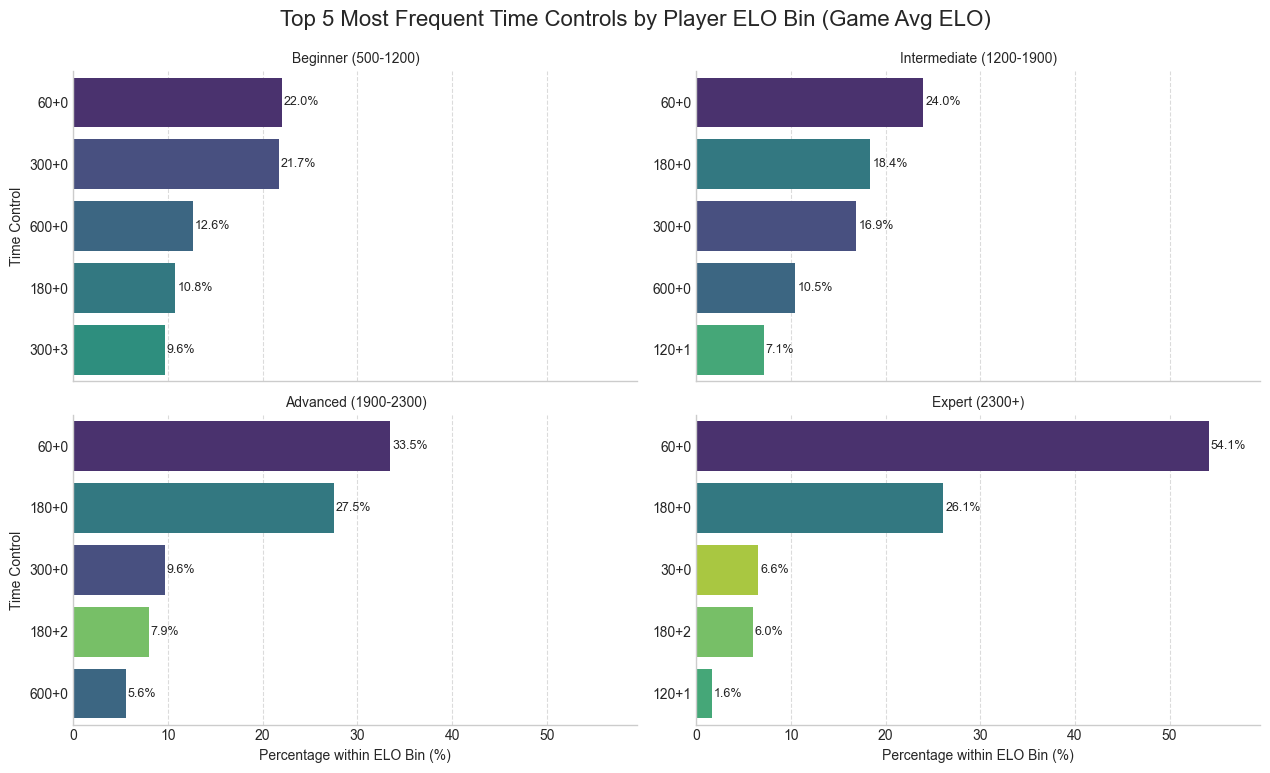

In [7]:
# --- Graph 1: Top Time Controls by ELO Bin ---

if not df_games_processed.empty:
    # --- Calculation for Graph 1 ---
    TOP_N_CONTROLS = 5
    results_tc = []
    grouped_games = df_games_processed.groupby('EloBin', observed=False)
    for name, group in grouped_games:
        tc_counts = group['TimeControl'].astype(str).value_counts()
        top_n_tc = tc_counts.head(TOP_N_CONTROLS)
        total_in_bin = len(group)
        if total_in_bin > 0:
            percentages = (top_n_tc / total_in_bin) * 100
            for tc, perc in percentages.items():
                results_tc.append({'EloBin': name, 'TimeControl': tc, 'PercentageInBin': perc})
    if results_tc:
        top_tc_by_elo = pd.DataFrame(results_tc)
        # --- Plotting for Graph 1 ---
        g = sns.catplot(
            data=top_tc_by_elo, x='PercentageInBin', y='TimeControl', col='EloBin',
            kind='bar', palette=plot_palette, height=4, aspect=1.6, col_wrap=2,
            sharex=True, sharey=False, col_order=elo_labels
        )
        g.set_axis_labels(f"Percentage within ELO Bin (%)", "Time Control")
        g.set_titles("{col_name}")
        for ax in g.axes.flat:
            ax.margins(x=0.1)
            for p in ax.patches:
                width = p.get_width()
                if isinstance(width, (int, float)) and not np.isnan(width):
                    ax.text(width + 0.2, p.get_y() + p.get_height() / 2., f'{width:.1f}%', va='center', fontsize=9)
            ax.grid(axis='x', linestyle='--', alpha=0.7)
        g.fig.suptitle(f'Top {TOP_N_CONTROLS} Most Frequent Time Controls by Player ELO Bin (Game Avg ELO)', y=0.96, fontsize=16)
        g.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
    else: print("No data for Graph 1 plot.")
else: print("Skipping Graph 1.")

**Graph 1 Interpretation:** 


Generating Graph 2a: Average Game Length & Std Dev by ELO Bin (Tight Bins)...


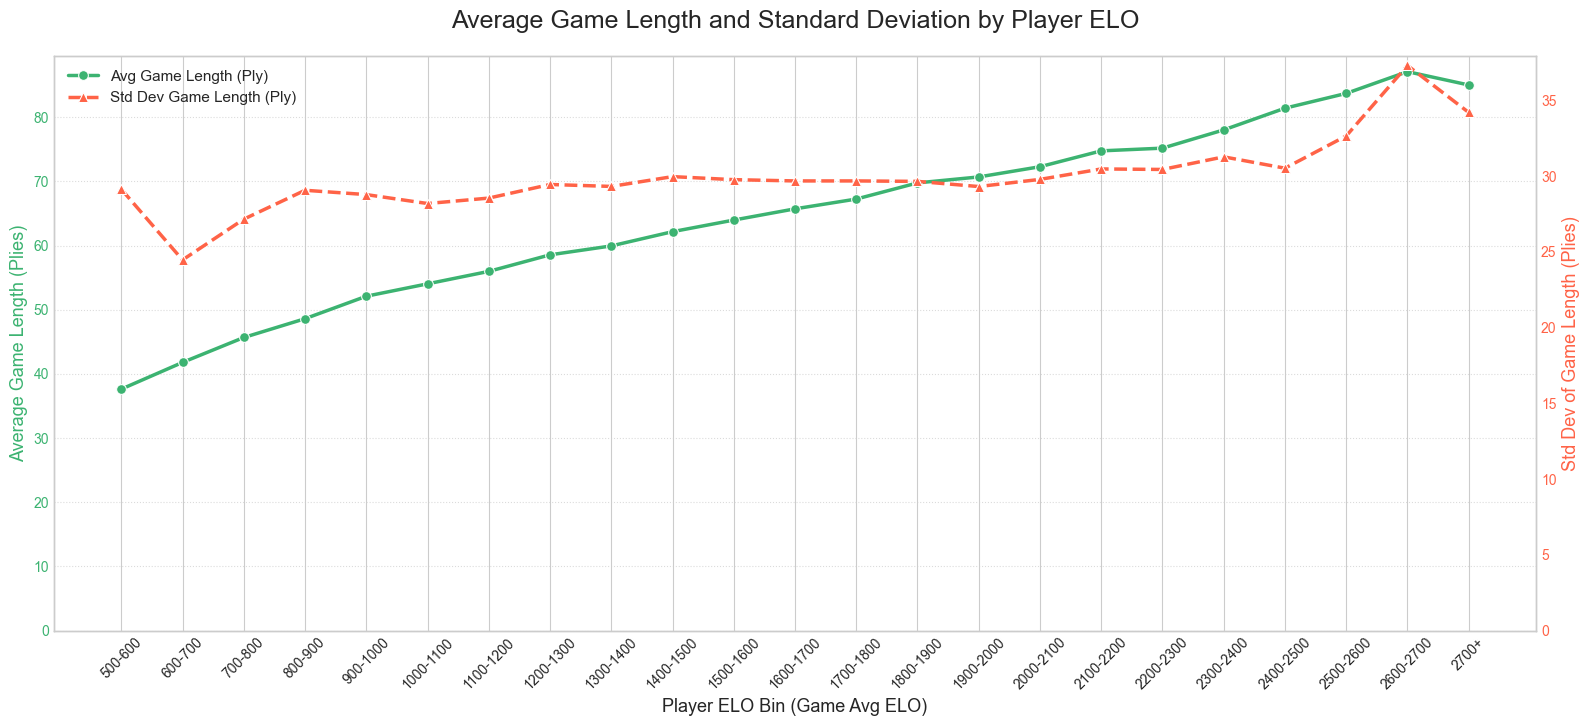

<Figure size 1200x700 with 0 Axes>

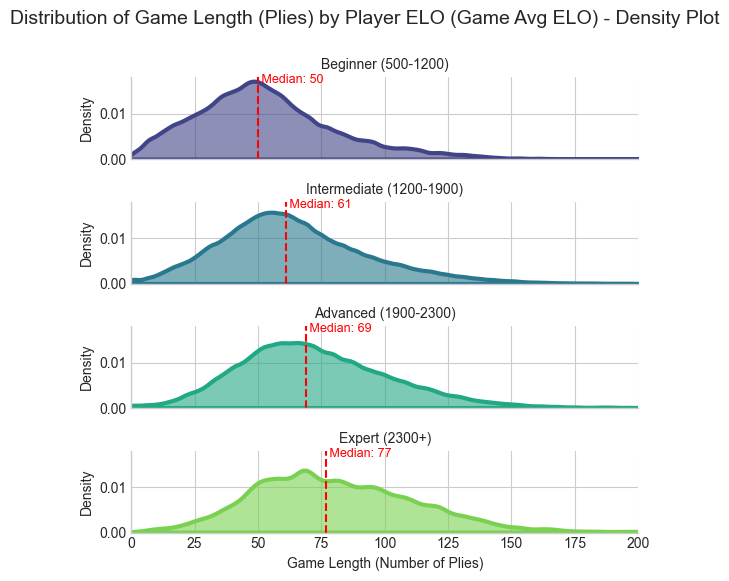

In [8]:
# --- Graph 2a: Distribution of Game Length by ELO Bin (Box Plot) ---

avg_len_color = 'mediumseagreen'
std_dev_len_color = 'tomato'

print("\nGenerating Graph 2a: Average Game Length & Std Dev by ELO Bin (Tight Bins)...")
if 'df_games_processed_tight' in locals() and not df_games_processed_tight.empty and 'GameLengthPly' in df_games_processed_tight.columns:

    # Calculate aggregations (Mean and Std Dev) for Game Length
    agg_len_stats = df_games_processed_tight.dropna(
        subset=['EloBinTight', 'GameLengthPly']).groupby('EloBinTight', observed=False).agg(
        Avg_GameLength=('GameLengthPly', 'mean'),
        StdDev_GameLength=('GameLengthPly', 'std')
        ).reset_index()

    # Handle potential NaNs if a bin has only one game (std dev is NaN)
    agg_len_stats['StdDev_GameLength'] = agg_len_stats['StdDev_GameLength'].fillna(0).clip(lower=0)
    agg_len_stats['Avg_GameLength'] = agg_len_stats['Avg_GameLength'].fillna(0)


    if not agg_len_stats.empty:
        # --- Plotting using Dual Axes ---
        fig, ax1 = plt.subplots(figsize=(16, 8))

        # Plot Avg Game Length on primary axis (ax1)
        sns.lineplot(x='EloBinTight', y='Avg_GameLength', data=agg_len_stats, marker='o', markersize=7, label='Avg Game Length (Ply)', color=avg_len_color, lw=2.5, ax=ax1)
        ax1.set_xlabel('Player ELO Bin (Game Avg ELO)', fontsize=13)
        ax1.set_ylabel('Average Game Length (Plies)', fontsize=13, color=avg_len_color)
        ax1.tick_params(axis='y', labelcolor=avg_len_color)
        ax1.set_ylim(bottom=0)
        ax1.grid(True, axis='y', linestyle=':', alpha=0.7)

        # Create secondary axis sharing the same x-axis
        ax2 = ax1.twinx()
        sns.lineplot(x='EloBinTight', y='StdDev_GameLength', data=agg_len_stats, marker='^', markersize=7, label='Std Dev Game Length (Ply)', color=std_dev_len_color, lw=2.5, linestyle='--', ax=ax2)
        ax2.set_ylabel('Std Dev of Game Length (Plies)', fontsize=13, color=std_dev_len_color)
        ax2.tick_params(axis='y', labelcolor=std_dev_len_color)
        ax2.set_ylim(bottom=0)
        ax2.grid(False)

        # Improve X-axis labels
        ax1.tick_params(axis='x', rotation=45, labelsize=10)
        if 'EloBinTight' in agg_len_stats.columns:
             ax1.set_xticks(np.arange(len(agg_len_stats['EloBinTight'])))
             ax1.set_xticklabels(agg_len_stats['EloBinTight'])

        # Add combined title and legend
        plt.title('Average Game Length and Standard Deviation by Player ELO', fontsize=18, pad=20)
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11) # Adjust loc if needed
        ax2.get_legend().remove()

        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("Could not calculate aggregated game length statistics.")
else:
    print("Skipping Graph 2a - df_games_processed_tight empty or required columns missing.")

# --- Graph 2b: Distribution of Game Length by ELO Bin (Density Plot) ---

if not df_games_processed.empty and 'GameLengthPly' in df_games_processed.columns:
    plt.figure(figsize=(12, 7))
    # Using FacetGrid for separate density plots can be clearer than overlaying many
    g = sns.FacetGrid(df_games_processed.dropna(subset=['GameLengthPly']),
        row="EloBin", # Create a row for each ELO bin
        hue="EloBin", # Color lines by ELO bin
        aspect=4,     # Width of each plot
        height=1.5,   # Height of each plot
        row_order=elo_labels,
        palette=plot_palette,
        sharex=True) # Share the X-axis

    # Map the density plot onto the grid
    g.map(sns.kdeplot, "GameLengthPly", fill=True, alpha=0.6, lw=3, bw_adjust=0.5) # bw_adjust controls smoothness
    # Optional: Map vertical lines for median/mean onto the grid
    def plot_median(data, **kwargs):
        median_val = data.median()
        plt.axvline(median_val, color='red', linestyle='--', lw=1.5)
        plt.text(median_val, plt.gca().get_ylim()[1]-0.002, 
             f' Median: {median_val:.0f}',
             horizontalalignment='left',
             verticalalignment='bottom',
             color='red',
             fontsize=9)
    g.map(plot_median, 'GameLengthPly')

    g.set_axis_labels("Game Length (Number of Plies)", "Density")
    g.set_titles(row_template="{row_name}", col_template="") # Set titles for rows
    g.figure.suptitle('Distribution of Game Length (Plies) by Player ELO (Game Avg ELO) - Density Plot', y=0.96, fontsize=14)
    # Adjust x-limits if needed, e.g., focus on the main range
    plt.xlim(0, 200)
    g.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("Skipping Graph 2b - df_games_processed empty or 'GameLengthPly' missing.")

**Graph 2 Interpretation:** 


Generating Graph 3: Avg Time Spent with Shaded Std Dev by ELO Bin (Tight Bins, for TCs: 60+0, 180+0)...


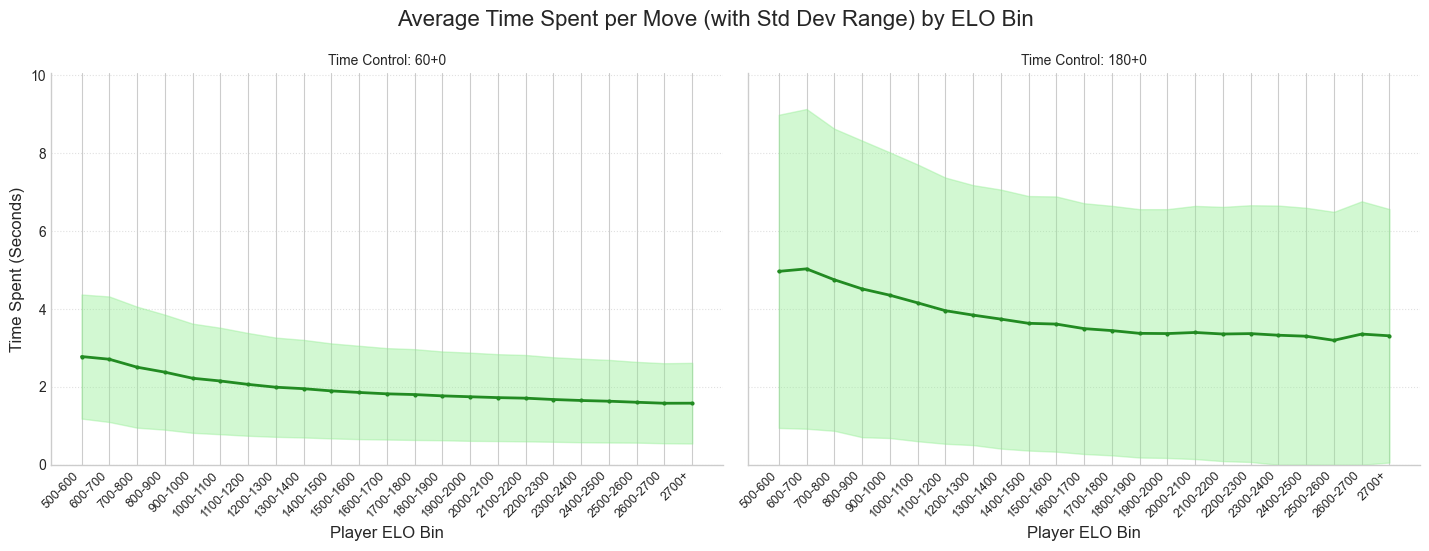

In [9]:
# --- Graph 3: Avg Time Spent & Std Dev per Move by ELO Bin (Tight Bins) ---

avg_time_color = 'forestgreen'
fill_color = 'lightgreen'  # Color for the shaded area

print(f"\nGenerating Graph 3: Avg Time Spent with Shaded Std Dev by ELO Bin (Tight Bins, for TCs: {', '.join(TARGET_TIME_CONTROLS)})...")
if not df_moves.empty and 'TimeSpentSec' in df_moves.columns and 'TimeControl' in df_moves.columns and 'EloBinTight' in df_moves.columns:

    # Filter for the target time controls
    df_moves_filtered_tc_tight = df_moves[df_moves['TimeControl'].isin(TARGET_TIME_CONTROLS)].copy()

    if not df_moves_filtered_tc_tight.empty:
        # Filter out negative/zero times and potentially extreme outliers for stability
        time_limit_q = 0.99  # Use 99th percentile to filter outliers
        df_plot_time_agg = pd.DataFrame()
        temp_list = []

        for tc in TARGET_TIME_CONTROLS:
             df_tc_subset = df_moves_filtered_tc_tight[df_moves_filtered_tc_tight['TimeControl'] == tc]
             if not df_tc_subset.empty:
                  limit = df_tc_subset['TimeSpentSec'].quantile(time_limit_q)
                  df_filtered = df_tc_subset[
                       (df_tc_subset['TimeSpentSec'].notna()) &
                       (df_tc_subset['TimeSpentSec'] > 0) &
                       (df_tc_subset['TimeSpentSec'] <= limit)
                  ].copy()
                  temp_list.append(df_filtered)

        if temp_list:
             df_plot_time_agg = pd.concat(temp_list)
        else:
             df_plot_time_agg = pd.DataFrame()

        if not df_plot_time_agg.empty:
            # Calculate aggregations (Mean and Std Dev) per TimeControl and Tight ELO Bin
            time_agg_stats = df_plot_time_agg.dropna(subset=['EloBinTight']).groupby(['TimeControl', 'EloBinTight'], observed=False).agg(
                Avg_TimeSpent=('TimeSpentSec', 'mean'),
                StdDev_TimeSpent=('TimeSpentSec', 'std')
            ).reset_index()

            # Ensure StdDev is not negative or NaN
            time_agg_stats['StdDev_TimeSpent'] = time_agg_stats['StdDev_TimeSpent'].fillna(0).clip(lower=0)
            time_agg_stats['Avg_TimeSpent'] = time_agg_stats['Avg_TimeSpent'].fillna(0)
            
            # Calculate upper and lower bounds for the shaded area
            time_agg_stats['Lower_Bound'] = (time_agg_stats['Avg_TimeSpent'] - time_agg_stats['StdDev_TimeSpent']).clip(lower=0)
            time_agg_stats['Upper_Bound'] = time_agg_stats['Avg_TimeSpent'] + time_agg_stats['StdDev_TimeSpent']

            if not time_agg_stats.empty:
                # --- Plotting using FacetGrid and mapping custom plot function with shaded area ---
                def plot_mean_with_shaded_std(data, **kwargs):
                    ax = plt.gca()
                    
                    # Get x positions for plotting
                    x_pos = np.arange(len(data['EloBinTight']))
                    
                    # Plot the main line
                    ax.plot(x_pos, data['Avg_TimeSpent'], 'o-', 
                           color=avg_time_color, 
                           linewidth=2, 
                           markersize=2,
                           label='Avg Time Spent')
                    
                    # Add shaded area for standard deviation
                    ax.fill_between(x_pos, 
                                   data['Lower_Bound'], 
                                   data['Upper_Bound'], 
                                   color=fill_color, 
                                   alpha=0.4,
                                   label='±1 Std Dev')
                    
                    # Set axis properties
                    ax.set_ylabel('Time Spent (Seconds)', fontsize=12)
                    
                    # Find the max upper bound for y-axis limit with some padding
                    y_max = data['Upper_Bound'].max() * 1.1
                    ax.set_ylim(bottom=0, top=y_max)
                    
                    # Set x-ticks and labels
                    ax.set_xticks(x_pos)
                    ax.set_xticklabels(data['EloBinTight'], rotation=45, ha='right', fontsize=9)
                    ax.set_xlabel('Player ELO Bin', fontsize=12)
                    
                    # Add grid
                    ax.grid(True, axis='y', linestyle=':', alpha=0.6)
                    
                    # Add legend
                    ax.legend(fontsize=10)

                # Calculate the maximum y value across all time controls for consistent y-axis
                max_upper = time_agg_stats.groupby('TimeControl')['Upper_Bound'].max().max() * 1.1
                
                # Create facet grid
                g = sns.FacetGrid(time_agg_stats, col="TimeControl", col_order=TARGET_TIME_CONTROLS,
                                  height=6, aspect=1.2, sharey=True)  # sharey=True for consistent y-axis
                g.map_dataframe(plot_mean_with_shaded_std)
                
                # Ensure consistent y-axis limits across facets
                for ax in g.axes.flat:
                    ax.set_ylim(0, max_upper)

                g.set_titles("Time Control: {col_name}")
                g.fig.suptitle(f'Average Time Spent per Move (with Std Dev Range) by ELO Bin', y=0.94, fontsize=16)
                g.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()

            else:
                print("Could not calculate aggregated time statistics.")
        else:
            print("No valid time data remaining after filtering for aggregation.")
    else:
        print(f"No data found for the target time controls: {TARGET_TIME_CONTROLS}")
else:
    print("Skipping Graph 3 - df_moves empty or required columns missing.")

**Graph 3 Interpretation:** 


Generating Combined Graph 4: Avg CPL & Std Dev per Move by ELO Bin (Tight Bins, with shaded error)...


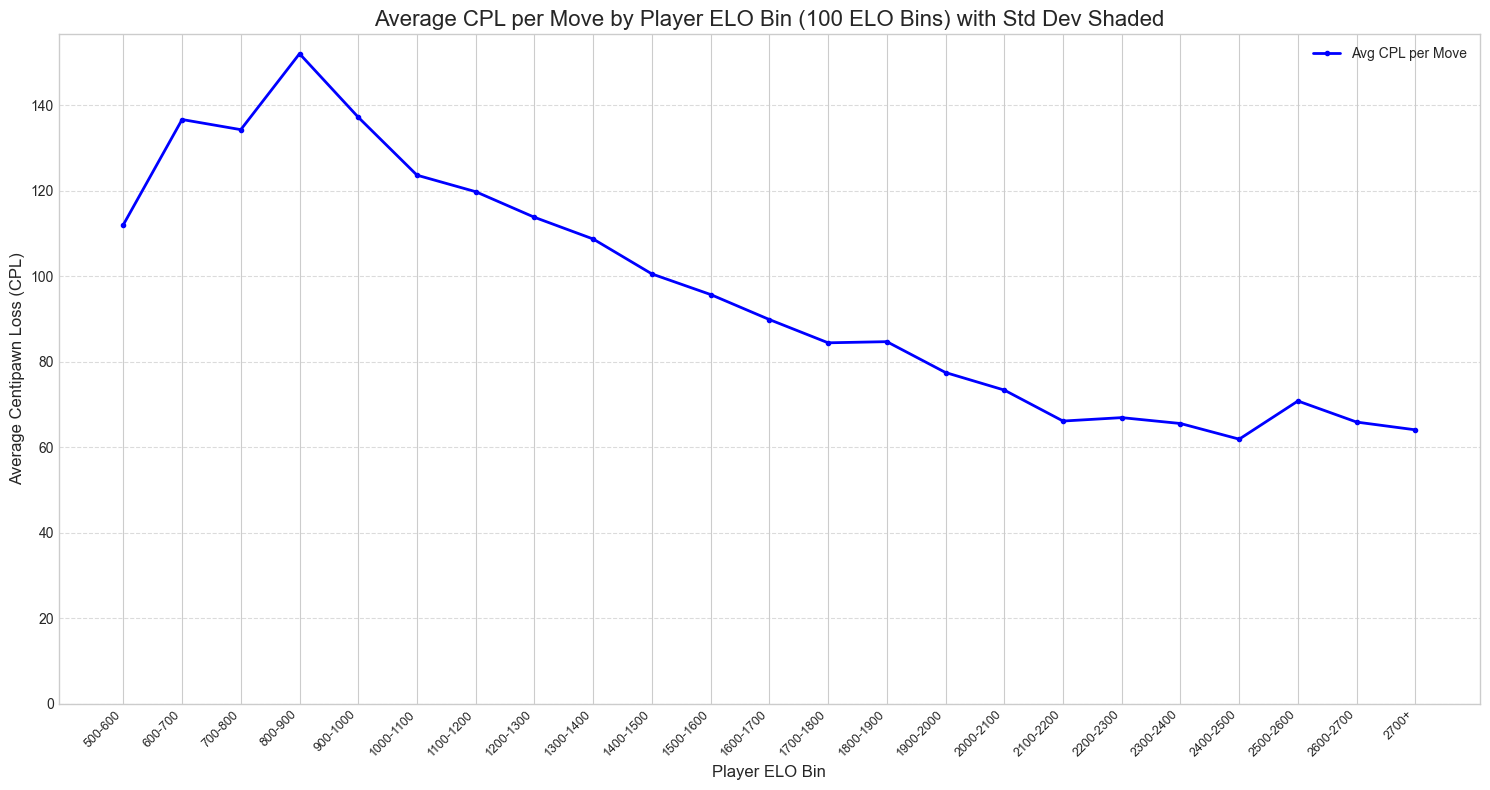

In [11]:
# --- Graph 4: Average Centipawn Loss per Move by ELO Bin --- 

print("\nGenerating Combined Graph 4: Avg CPL & Std Dev per Move by ELO Bin (Tight Bins, with shaded error)...")
if not df_moves.empty and 'CPLoss' in df_moves.columns and 'EloBinTight' in df_moves.columns:

    # --- Calculate Aggregations ---
    eval_change_min = -100.0
    eval_change_max = 100.0
    df_moves_filtered_agg = df_moves[
        df_moves['PlayerRelativeEvalChange'].notna() &
        df_moves['CPLoss'].notna() &
        df_moves['PlayerRelativeEvalChange'].between(eval_change_min, eval_change_max)
    ].copy()

    if not df_moves_filtered_agg.empty:
        agg_stats = df_moves_filtered_agg.dropna(subset=['EloBinTight']).groupby('EloBinTight', observed=False).agg(
            Avg_CPLoss_Per_Move=('CPLoss', 'mean'),
            StdErr_CPLoss=('CPLoss', lambda x: x.std() / np.sqrt(len(x)))
        ).reset_index()
        agg_stats['Avg_CPLoss_Per_Move'] = agg_stats['Avg_CPLoss_Per_Move'].fillna(0) * 100

        if not agg_stats.empty:
            plt.figure(figsize=(15, 8))
            x = np.arange(len(agg_stats['EloBinTight']))
            plt.plot(x, agg_stats['Avg_CPLoss_Per_Move'], marker='o', markersize = 3, label='Avg CPL per Move', color='blue', lw=2)
            
            plt.title('Average CPL per Move by Player ELO Bin (100 ELO Bins) with Std Dev Shaded', fontsize=16)
            plt.xlabel('Player ELO Bin', fontsize=12)
            plt.ylabel('Average Centipawn Loss (CPL)', fontsize=12)
            plt.xticks(x, agg_stats['EloBinTight'], rotation=45, ha='right', fontsize=9)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.legend()
            plt.ylim(bottom=0)
            plt.tight_layout()
            plt.show()
        else:
            print("Could not calculate aggregated statistics.")
    else:
        print("No valid data remaining after filtering for aggregation.")
else:
    print("Skipping Combined Graph 4/6 - df_moves empty or required columns missing.")

**Graph 4 Interpretation:** 


Generating Graph 5: Castling Frequency per game by ELO Bin...


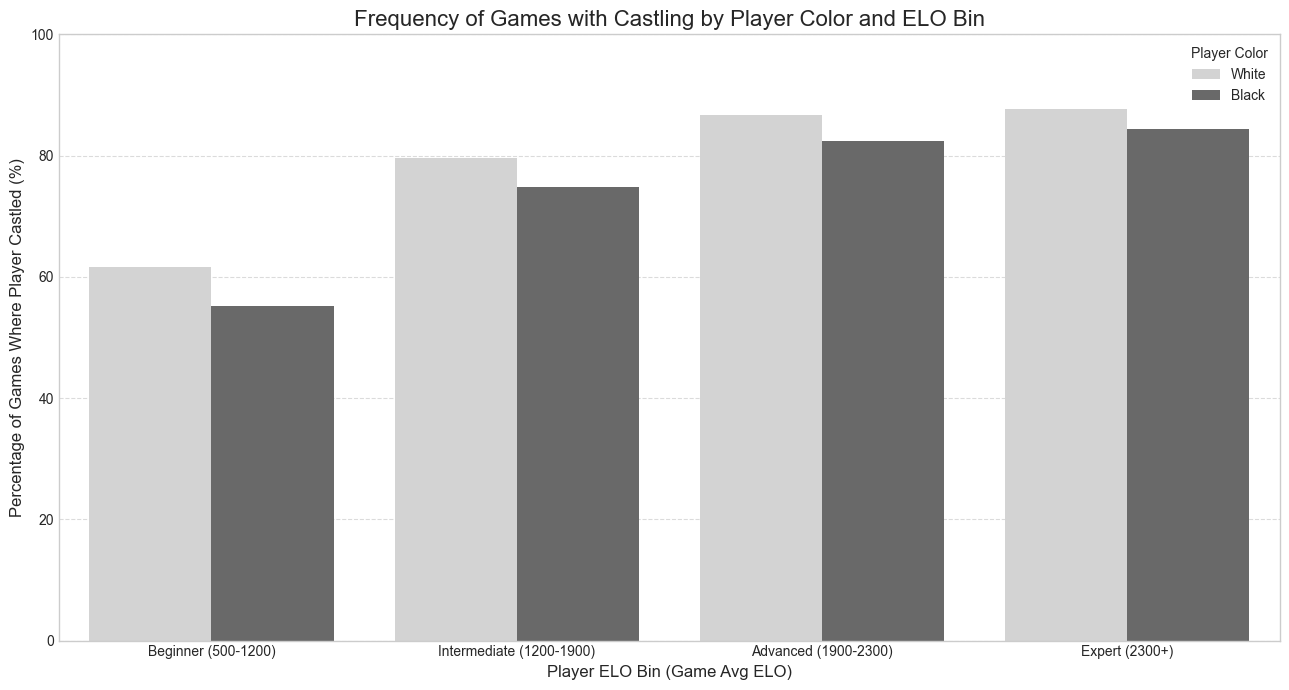

In [ ]:
# --- Graph 5: Castling Frequency by ELO Bin ---

print("\nGenerating Graph 5: Castling Frequency per game by ELO Bin...")
if not df_games_processed.empty and 'WhiteCastled' in df_games_processed.columns and 'BlackCastled' in df_games_processed.columns:
    # Calculate proportion of games where White/Black castled
    castling_game_props = df_games_processed.groupby('EloBin', observed=True).agg(
        WhiteCastledRate=('WhiteCastled', 'mean'),
        BlackCastledRate=('BlackCastled', 'mean'),
        GamesInBin=('GameID', 'count') # Get count for context
    ).reset_index()
    castling_game_props['WhiteCastledRate'] *= 100
    castling_game_props['BlackCastledRate'] *= 100

    if not castling_game_props.empty:
        # Melt dataframe for easier plotting with seaborn barplot (one row per color per bin)
        df_plot_castle = pd.melt(castling_game_props, id_vars=['EloBin', 'GamesInBin'],
                                 value_vars=['WhiteCastledRate', 'BlackCastledRate'],
                                 var_name='PlayerColor', value_name='CastlingPercentage')
        df_plot_castle['PlayerColor'] = df_plot_castle['PlayerColor'].replace({'WhiteCastledRate': 'White', 'BlackCastledRate': 'Black'})


        plt.figure(figsize=(13, 7))
        sns.barplot(x='EloBin', y='CastlingPercentage', hue='PlayerColor', data=df_plot_castle, order=elo_labels, palette={'White': 'lightgray', 'Black': 'dimgray'})
        plt.title('Frequency of Games with Castling by Player Color and ELO Bin', fontsize=16)
        plt.xlabel('Player ELO Bin (Game Avg ELO)', fontsize=12)
        plt.ylabel('Percentage of Games Where Player Castled (%)', fontsize=12)
        plt.ylim(0, 100)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(title='Player Color')
        # Add data labels (optional)
        # Add code here similar to other bar plots if desired, iterating through patches

        plt.tight_layout()
        plt.show()
    else:
        print("Could not calculate castling rates per game.")
else:
    print("Skipping Graph 5 - df_games_processed empty or castling columns missing.")

**Graph 5 Interpretation:** 